# ResEmoteNetCNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
    
    
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_ch)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
    
class ResEmoteNet(nn.Module):
    def __init__(self):
        super(ResEmoteNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(128)
        
        self.res_block1 = ResidualBlock(128, 256, stride=2)
        self.res_block2 = ResidualBlock(256, 512, stride=2)
        self.res_block3 = ResidualBlock(512, 1024, stride=2)
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(128, 7)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.se(x)
        
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

# Training with ResEmoteNetCNN Model

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((48, 48)),  # Standard size for FER2013
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Grayscale normalization
])

test_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root='/kaggle/input/fer2013/train',
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root='/kaggle/input/fer2013/test',  
    transform=test_transform
)

BATCH_SIZE = 16

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# Initialize model, criterion, and optimizer
model = ResEmoteNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Training parameters
num_epochs = 80
patience = 15
best_val_acc = 0
patience_counter = 0
epoch_counter = 0

# History tracking
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{train_loss/train_total:.4f}',
            'acc': f'{100.*train_correct/train_total:.2f}%'
        })
    
    train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'\nEpoch {epoch+1}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
        }, 'ResEmoteNetCNN_model.pth')
    else:
        patience_counter += 1
        print(f'No improvement for {patience_counter} epochs.')
        
    if patience_counter >= patience:
        print('Early stopping triggered.')
        break
    
    epoch_counter += 1

# Save final results
num_epochs_completed = len(history['train_loss'])  # Menggunakan panjang aktual dari history
results_df = pd.DataFrame({
    'Epoch': range(1, num_epochs_completed + 1),
    'Train Loss': history['train_loss'],
    'Val Loss': history['val_loss'],
    'Train Acc': history['train_acc'],
    'Val Acc': history['val_acc']
})
results_df.to_csv('training_history.csv', index=False)

Using cuda device
Training set size: 28709
Validation set size: 7178


Validation: 100%|██████████| 449/449 [00:25<00:00, 17.78it/s]



Epoch 1:
Train Loss: 1.7792, Train Acc: 0.2683
Val Loss: 1.6199, Val Acc: 0.3600


Validation: 100%|██████████| 449/449 [00:09<00:00, 46.50it/s]



Epoch 2:
Train Loss: 1.6449, Train Acc: 0.3457
Val Loss: 1.5344, Val Acc: 0.3860


Validation: 100%|██████████| 449/449 [00:09<00:00, 46.60it/s]



Epoch 3:
Train Loss: 1.5765, Train Acc: 0.3870
Val Loss: 1.4464, Val Acc: 0.4291


Validation: 100%|██████████| 449/449 [00:08<00:00, 52.27it/s]



Epoch 4:
Train Loss: 1.5140, Train Acc: 0.4123
Val Loss: 1.4255, Val Acc: 0.4553


Validation: 100%|██████████| 449/449 [00:09<00:00, 49.64it/s]



Epoch 5:
Train Loss: 1.4713, Train Acc: 0.4346
Val Loss: 1.3286, Val Acc: 0.4915


Validation: 100%|██████████| 449/449 [00:09<00:00, 46.34it/s]



Epoch 6:
Train Loss: 1.4361, Train Acc: 0.4507
Val Loss: 1.2933, Val Acc: 0.4947


Validation: 100%|██████████| 449/449 [00:09<00:00, 49.63it/s]



Epoch 7:
Train Loss: 1.4109, Train Acc: 0.4616
Val Loss: 1.2793, Val Acc: 0.5123


Validation: 100%|██████████| 449/449 [00:09<00:00, 49.22it/s]



Epoch 8:
Train Loss: 1.3743, Train Acc: 0.4758
Val Loss: 1.2442, Val Acc: 0.5189


Validation: 100%|██████████| 449/449 [00:09<00:00, 49.52it/s]



Epoch 9:
Train Loss: 1.3568, Train Acc: 0.4841
Val Loss: 1.2308, Val Acc: 0.5159
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 50.40it/s]



Epoch 10:
Train Loss: 1.3309, Train Acc: 0.4969
Val Loss: 1.2305, Val Acc: 0.5293


Validation: 100%|██████████| 449/449 [00:09<00:00, 48.42it/s]



Epoch 11:
Train Loss: 1.3136, Train Acc: 0.5011
Val Loss: 1.2118, Val Acc: 0.5323


Validation: 100%|██████████| 449/449 [00:09<00:00, 47.58it/s]



Epoch 12:
Train Loss: 1.3061, Train Acc: 0.5074
Val Loss: 1.1948, Val Acc: 0.5336


Validation: 100%|██████████| 449/449 [00:09<00:00, 47.69it/s]



Epoch 13:
Train Loss: 1.2881, Train Acc: 0.5145
Val Loss: 1.1781, Val Acc: 0.5507


Validation: 100%|██████████| 449/449 [00:09<00:00, 49.67it/s]



Epoch 14:
Train Loss: 1.2820, Train Acc: 0.5237
Val Loss: 1.1629, Val Acc: 0.5577


Validation: 100%|██████████| 449/449 [00:09<00:00, 46.72it/s]



Epoch 15:
Train Loss: 1.2650, Train Acc: 0.5289
Val Loss: 1.1656, Val Acc: 0.5563
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:23<00:00, 19.22it/s]



Epoch 16:
Train Loss: 1.2592, Train Acc: 0.5308
Val Loss: 1.1686, Val Acc: 0.5517
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 45.46it/s]



Epoch 17:
Train Loss: 1.2528, Train Acc: 0.5323
Val Loss: 1.1495, Val Acc: 0.5698


Validation: 100%|██████████| 449/449 [00:09<00:00, 44.93it/s]



Epoch 18:
Train Loss: 1.2395, Train Acc: 0.5402
Val Loss: 1.1489, Val Acc: 0.5598
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 46.99it/s]



Epoch 19:
Train Loss: 1.2221, Train Acc: 0.5477
Val Loss: 1.1284, Val Acc: 0.5731


Validation: 100%|██████████| 449/449 [00:09<00:00, 46.71it/s]



Epoch 20:
Train Loss: 1.2220, Train Acc: 0.5492
Val Loss: 1.1427, Val Acc: 0.5563
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 47.28it/s]



Epoch 21:
Train Loss: 1.2000, Train Acc: 0.5565
Val Loss: 1.1437, Val Acc: 0.5684
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 46.79it/s]



Epoch 22:
Train Loss: 1.2055, Train Acc: 0.5536
Val Loss: 1.1124, Val Acc: 0.5769


Validation: 100%|██████████| 449/449 [00:09<00:00, 46.70it/s]



Epoch 23:
Train Loss: 1.1932, Train Acc: 0.5603
Val Loss: 1.0992, Val Acc: 0.5882


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.58it/s]



Epoch 24:
Train Loss: 1.1812, Train Acc: 0.5648
Val Loss: 1.1117, Val Acc: 0.5748
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.06it/s]



Epoch 25:
Train Loss: 1.1732, Train Acc: 0.5664
Val Loss: 1.0921, Val Acc: 0.5926


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.66it/s]



Epoch 26:
Train Loss: 1.1653, Train Acc: 0.5735
Val Loss: 1.0896, Val Acc: 0.5851
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 48.09it/s]



Epoch 27:
Train Loss: 1.1515, Train Acc: 0.5786
Val Loss: 1.1196, Val Acc: 0.5811
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 47.91it/s]



Epoch 28:
Train Loss: 1.1509, Train Acc: 0.5810
Val Loss: 1.0978, Val Acc: 0.5924
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 45.77it/s]



Epoch 29:
Train Loss: 1.1455, Train Acc: 0.5807
Val Loss: 1.0749, Val Acc: 0.5965


Validation: 100%|██████████| 449/449 [00:08<00:00, 50.51it/s]



Epoch 30:
Train Loss: 1.1407, Train Acc: 0.5842
Val Loss: 1.0734, Val Acc: 0.5995


Validation: 100%|██████████| 449/449 [00:09<00:00, 48.03it/s]



Epoch 31:
Train Loss: 1.1273, Train Acc: 0.5868
Val Loss: 1.0685, Val Acc: 0.6048


Validation: 100%|██████████| 449/449 [00:09<00:00, 45.65it/s]



Epoch 32:
Train Loss: 1.1214, Train Acc: 0.5925
Val Loss: 1.0796, Val Acc: 0.5896
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 49.60it/s]



Epoch 33:
Train Loss: 1.1188, Train Acc: 0.5897
Val Loss: 1.0807, Val Acc: 0.6021
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 50.12it/s]



Epoch 34:
Train Loss: 1.1110, Train Acc: 0.5952
Val Loss: 1.0727, Val Acc: 0.6055


Validation: 100%|██████████| 449/449 [00:08<00:00, 51.36it/s]



Epoch 35:
Train Loss: 1.1079, Train Acc: 0.5973
Val Loss: 1.0624, Val Acc: 0.6098


Validation: 100%|██████████| 449/449 [00:09<00:00, 46.35it/s]



Epoch 36:
Train Loss: 1.1011, Train Acc: 0.5988
Val Loss: 1.0696, Val Acc: 0.5986
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 52.83it/s]



Epoch 37:
Train Loss: 1.0917, Train Acc: 0.5994
Val Loss: 1.0692, Val Acc: 0.6067
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 50.12it/s]



Epoch 38:
Train Loss: 1.0820, Train Acc: 0.6086
Val Loss: 1.0625, Val Acc: 0.6089
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 45.44it/s]



Epoch 39:
Train Loss: 1.0739, Train Acc: 0.6060
Val Loss: 1.0639, Val Acc: 0.6089
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 50.48it/s]



Epoch 40:
Train Loss: 1.0752, Train Acc: 0.6112
Val Loss: 1.0720, Val Acc: 0.6142


Validation: 100%|██████████| 449/449 [00:09<00:00, 48.48it/s]



Epoch 41:
Train Loss: 1.0660, Train Acc: 0.6149
Val Loss: 1.0545, Val Acc: 0.6088
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 49.92it/s]



Epoch 42:
Train Loss: 1.0651, Train Acc: 0.6163
Val Loss: 1.0543, Val Acc: 0.6109
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.36it/s]



Epoch 43:
Train Loss: 1.0514, Train Acc: 0.6237
Val Loss: 1.0319, Val Acc: 0.6173


Validation: 100%|██████████| 449/449 [00:08<00:00, 51.13it/s]



Epoch 44:
Train Loss: 1.0443, Train Acc: 0.6227
Val Loss: 1.0541, Val Acc: 0.6218


Validation: 100%|██████████| 449/449 [00:08<00:00, 51.91it/s]



Epoch 45:
Train Loss: 1.0375, Train Acc: 0.6252
Val Loss: 1.0957, Val Acc: 0.6062
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 48.95it/s]



Epoch 46:
Train Loss: 1.0340, Train Acc: 0.6309
Val Loss: 1.0394, Val Acc: 0.6234


Validation: 100%|██████████| 449/449 [00:08<00:00, 51.41it/s]



Epoch 47:
Train Loss: 1.0212, Train Acc: 0.6334
Val Loss: 1.2370, Val Acc: 0.6066
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 51.12it/s]



Epoch 48:
Train Loss: 1.0215, Train Acc: 0.6304
Val Loss: 1.0378, Val Acc: 0.6141
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 51.57it/s]



Epoch 49:
Train Loss: 1.0156, Train Acc: 0.6382
Val Loss: 1.0728, Val Acc: 0.6096
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.44it/s]



Epoch 50:
Train Loss: 1.0128, Train Acc: 0.6352
Val Loss: 1.0372, Val Acc: 0.6230
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 48.53it/s]



Epoch 51:
Train Loss: 0.9992, Train Acc: 0.6372
Val Loss: 1.0383, Val Acc: 0.6213
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 49.69it/s]



Epoch 52:
Train Loss: 0.9954, Train Acc: 0.6439
Val Loss: 1.3106, Val Acc: 0.6124
No improvement for 6 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 48.51it/s]



Epoch 53:
Train Loss: 1.0035, Train Acc: 0.6404
Val Loss: 1.0475, Val Acc: 0.6219
No improvement for 7 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 49.96it/s]



Epoch 54:
Train Loss: 0.9856, Train Acc: 0.6449
Val Loss: 1.0706, Val Acc: 0.6219
No improvement for 8 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 50.21it/s]



Epoch 55:
Train Loss: 0.9810, Train Acc: 0.6463
Val Loss: 1.0469, Val Acc: 0.6225
No improvement for 9 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 50.65it/s]



Epoch 56:
Train Loss: 0.9753, Train Acc: 0.6522
Val Loss: 1.0962, Val Acc: 0.6236


Validation: 100%|██████████| 449/449 [00:09<00:00, 47.39it/s]



Epoch 57:
Train Loss: 0.9790, Train Acc: 0.6489
Val Loss: 1.0623, Val Acc: 0.6314


Validation: 100%|██████████| 449/449 [00:08<00:00, 49.96it/s]



Epoch 58:
Train Loss: 0.9603, Train Acc: 0.6583
Val Loss: 1.0988, Val Acc: 0.6141
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 49.46it/s]



Epoch 59:
Train Loss: 0.9903, Train Acc: 0.6515
Val Loss: 1.0542, Val Acc: 0.6219
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 50.00it/s]



Epoch 60:
Train Loss: 0.9510, Train Acc: 0.6583
Val Loss: 1.1021, Val Acc: 0.6145
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 48.84it/s]



Epoch 61:
Train Loss: 0.9427, Train Acc: 0.6666
Val Loss: 1.1156, Val Acc: 0.6141
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 50.19it/s]



Epoch 62:
Train Loss: 0.9435, Train Acc: 0.6630
Val Loss: 1.3311, Val Acc: 0.6186
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 51.86it/s]



Epoch 63:
Train Loss: 0.9417, Train Acc: 0.6664
Val Loss: 1.6516, Val Acc: 0.6121
No improvement for 6 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 49.92it/s]



Epoch 64:
Train Loss: 0.9326, Train Acc: 0.6702
Val Loss: 1.0990, Val Acc: 0.6301
No improvement for 7 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 50.05it/s]



Epoch 65:
Train Loss: 0.9227, Train Acc: 0.6721
Val Loss: 1.1056, Val Acc: 0.6199
No improvement for 8 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 52.95it/s]



Epoch 66:
Train Loss: 0.9166, Train Acc: 0.6752
Val Loss: 1.0725, Val Acc: 0.6250
No improvement for 9 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 50.30it/s]



Epoch 67:
Train Loss: 0.9183, Train Acc: 0.6752
Val Loss: 1.1258, Val Acc: 0.6176
No improvement for 10 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 49.72it/s]



Epoch 68:
Train Loss: 0.9238, Train Acc: 0.6757
Val Loss: 1.0890, Val Acc: 0.6332


Validation: 100%|██████████| 449/449 [00:08<00:00, 51.58it/s]



Epoch 69:
Train Loss: 0.9146, Train Acc: 0.6737
Val Loss: 1.0524, Val Acc: 0.6350


Validation: 100%|██████████| 449/449 [00:08<00:00, 50.76it/s]



Epoch 70:
Train Loss: 0.9037, Train Acc: 0.6830
Val Loss: 1.1305, Val Acc: 0.6239
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 51.83it/s]



Epoch 71:
Train Loss: 0.8980, Train Acc: 0.6803
Val Loss: 1.0772, Val Acc: 0.6296
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 45.87it/s]



Epoch 72:
Train Loss: 0.8989, Train Acc: 0.6806
Val Loss: 1.0954, Val Acc: 0.6308
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 52.56it/s]



Epoch 73:
Train Loss: 0.8892, Train Acc: 0.6869
Val Loss: 1.1342, Val Acc: 0.6265
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 50.96it/s]



Epoch 74:
Train Loss: 0.8844, Train Acc: 0.6885
Val Loss: 1.1074, Val Acc: 0.6378


Validation: 100%|██████████| 449/449 [00:08<00:00, 51.75it/s]



Epoch 75:
Train Loss: 0.8821, Train Acc: 0.6908
Val Loss: 1.0940, Val Acc: 0.6337
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 48.00it/s]



Epoch 76:
Train Loss: 0.8813, Train Acc: 0.6927
Val Loss: 1.3459, Val Acc: 0.6315
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 49.66it/s]



Epoch 77:
Train Loss: 0.9145, Train Acc: 0.6780
Val Loss: 1.2267, Val Acc: 0.6339
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 51.71it/s]



Epoch 78:
Train Loss: 0.8497, Train Acc: 0.7018
Val Loss: 1.1435, Val Acc: 0.6353
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 49.23it/s]



Epoch 79:
Train Loss: 0.8531, Train Acc: 0.7030
Val Loss: 1.2880, Val Acc: 0.6282
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:08<00:00, 51.06it/s]


Epoch 80:
Train Loss: 0.8490, Train Acc: 0.7038
Val Loss: 1.2381, Val Acc: 0.6375
No improvement for 6 epochs.


In [3]:
import warnings
warnings.filterwarnings('ignore')

def convert_pth_to_pt(model_path, output_path='model.pt'):
    """
    Convert .pth checkpoint to .pt format
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        output_path (str): Path to save the .pt model file
    Returns:
        str: Path to saved .pt model
    """
    try:
        # Initialize model
        model = ResEmoteNet()
        
        # Load checkpoint
        checkpoint = torch.load(model_path)
        
        # Load state dict
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Set model to eval mode
        model.eval()
        
        # Save model in .pt format
        torch.save(model, output_path)
        
        print(f"Successfully converted model to {output_path}")
        return output_path
        
    except Exception as e:
        print(f"Error converting model: {str(e)}")
        return None

def convert_pth_to_ptl(model_path, output_path='model.ptl'):
    """
    Convert .pth checkpoint to .ptl (PyTorch Lightning) format
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        output_path (str): Path to save the .ptl model file
    Returns:
        str: Path to saved .ptl model
    """
    try:
        # Initialize model
        model = ResEmoteNet()
        
        # Load checkpoint
        checkpoint = torch.load(model_path)
        
        # Create new state dict with Lightning compatible format
        new_state_dict = {
            'state_dict': checkpoint['model_state_dict'],
            'epoch': checkpoint.get('epoch', 0),
            'global_step': 0,
            'pytorch-lightning_version': '2.0.0',
            'callbacks': {},
            'optimizer_states': [checkpoint.get('optimizer_state_dict', {})],
            'lr_schedulers': [],
            'hparams_name': 'ResEmoteNet',
            'hyper_parameters': {
                'learning_rate': 0.001,
                'batch_size': 16,
                'num_classes': 7
            }
        }
        
        # Save in Lightning format
        torch.save(new_state_dict, output_path)
        
        print(f"Successfully converted model to {output_path}")
        return output_path
        
    except Exception as e:
        print(f"Error converting model: {str(e)}")
        return None

def convert_all_formats(model_path, base_output_name='model'):
    """
    Convert .pth model to both .pt and .ptl formats
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        base_output_name (str): Base name for output files
    Returns:
        tuple: Paths to saved .pt and .ptl models
    """
    pt_path = f"{base_output_name}.pt"
    ptl_path = f"{base_output_name}.ptl"
    
    pt_result = convert_pth_to_pt(model_path, pt_path)
    ptl_result = convert_pth_to_ptl(model_path, ptl_path)
    
    return pt_result, ptl_result

# Example usage:
"""
# For single format conversion:
pt_path = convert_pth_to_pt('ResEmoteNetCNN_model.pth')
# or
ptl_path = convert_pth_to_ptl('ResEmoteNetCNN_model.pth')

# For converting to both formats:
pt_path, ptl_path = convert_all_formats('ResEmoteNetCNN_model.pth', 'ResEmoteNet')
"""

def plot_training_curves(history):
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Training Analysis', fontsize=16, y=1.05)

    # Loss curves
    axes[0,0].plot(history['train_loss'], label='Training Loss', color='blue')
    axes[0,0].plot(history['val_loss'], label='Validation Loss', color='red')
    axes[0,0].set_title('Loss Curves')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Accuracy curves
    axes[0,1].plot(history['train_acc'], label='Training Accuracy', color='blue')
    axes[0,1].plot(history['val_acc'], label='Validation Accuracy', color='red')
    axes[0,1].set_title('Accuracy Curves')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Learning curves (Training vs Validation Gap)
    train_val_gap = np.array(history['train_acc']) - np.array(history['val_acc'])
    axes[1,0].plot(train_val_gap, label='Train-Val Accuracy Gap', color='purple')
    axes[1,0].set_title('Overfitting Analysis')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Accuracy Gap')
    axes[1,0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
    axes[1,0].legend()
    axes[1,0].grid(True)

    # Learning Rate if available
    if 'lr' in history:
        axes[1,1].plot(history['lr'], label='Learning Rate', color='green')
        axes[1,1].set_title('Learning Rate Schedule')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Learning Rate')
        axes[1,1].set_yscale('log')
        axes[1,1].legend()
        axes[1,1].grid(True)
    else:
        fig.delaxes(axes[1,1])  # Better way to remove subplot

    plt.tight_layout()
    plt.savefig('training_curves.png', bbox_inches='tight', dpi=300)
    plt.show()

def evaluate_model(model, val_loader, device, class_names):

    model.eval()
    all_preds = []
    all_labels = []
    
    try:
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Create confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        
        # Plot confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
        plt.show()
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")

def plot_sample_predictions(model, val_loader, device, class_names, num_samples=5):

    model.eval()
    
    try:
        fig, axes = plt.subplots(2, num_samples, figsize=(20, 6))
        
        with torch.no_grad():
            inputs, labels = next(iter(val_loader))
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            
            for i in range(min(num_samples, len(inputs))):
                # Plot image
                img = inputs[i].cpu().permute(1, 2, 0)
                img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
                img = img.clip(0, 1)
                
                axes[0, i].imshow(img)
                axes[0, i].axis('off')
                true_label = class_names[labels[i]]
                pred_label = class_names[outputs[i].argmax()]
                axes[0, i].set_title(f'True: {true_label}\nPred: {pred_label}',
                                   color='green' if true_label == pred_label else 'red')
                
                # Plot probability distribution
                probs = probabilities[i].cpu().numpy()
                axes[1, i].bar(range(len(class_names)), probs)
                axes[1, i].set_xticks(range(len(class_names)))
                axes[1, i].set_xticklabels(class_names, rotation=45)
                axes[1, i].set_ylim(0, 1)
        
        plt.tight_layout()
        plt.savefig('sample_predictions.png', bbox_inches='tight', dpi=300)
        plt.show()
        
    except Exception as e:
        print(f"Error plotting predictions: {str(e)}")

def print_parameter_details(model):
    """
    Print model parameter details and total trainable parameters.
    
    Args:
        model (torch.nn.Module): The model to analyze
    """
    try:
        total_params = 0
        print("\nModel Parameter Details:")
        print("-" * 50)
        for name, parameter in model.named_parameters():
            if parameter.requires_grad:
                params = parameter.numel()
                total_params += params
                print(f"{name:<30} {params:>10,d}")
        print("-" * 50)
        print(f"Total trainable parameters: {total_params:,}")
        
    except Exception as e:
        print(f"Error analyzing parameters: {str(e)}")


Model Parameter Details:
--------------------------------------------------
conv1.weight                          288
conv1.bias                             32
bn1.weight                             32
bn1.bias                               32
conv2.weight                       18,432
conv2.bias                             64
bn2.weight                             64
bn2.bias                               64
conv3.weight                       73,728
conv3.bias                            128
bn3.weight                            128
bn3.bias                              128
se.fc.0.weight                      1,024
se.fc.2.weight                      1,024
res_block1.conv1.weight           294,912
res_block1.conv1.bias                 256
res_block1.bn1.weight                 256
res_block1.bn1.bias                   256
res_block1.conv2.weight           589,824
res_block1.conv2.bias                 256
res_block1.bn2.weight                 256
res_block1.bn2.bias                   256

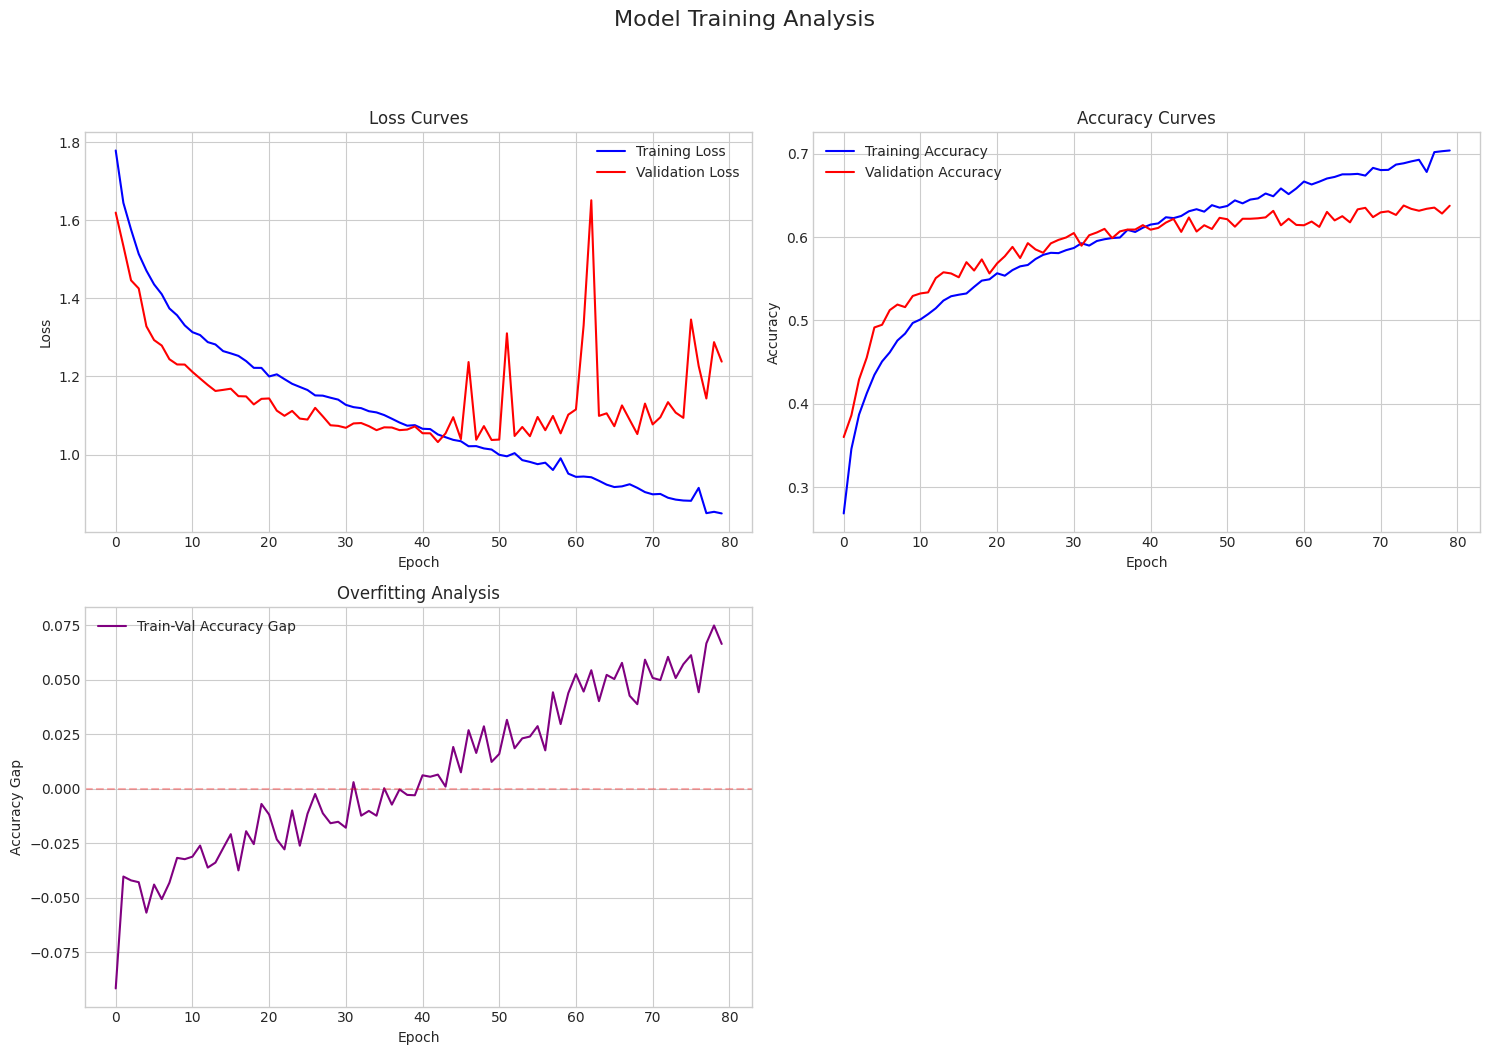

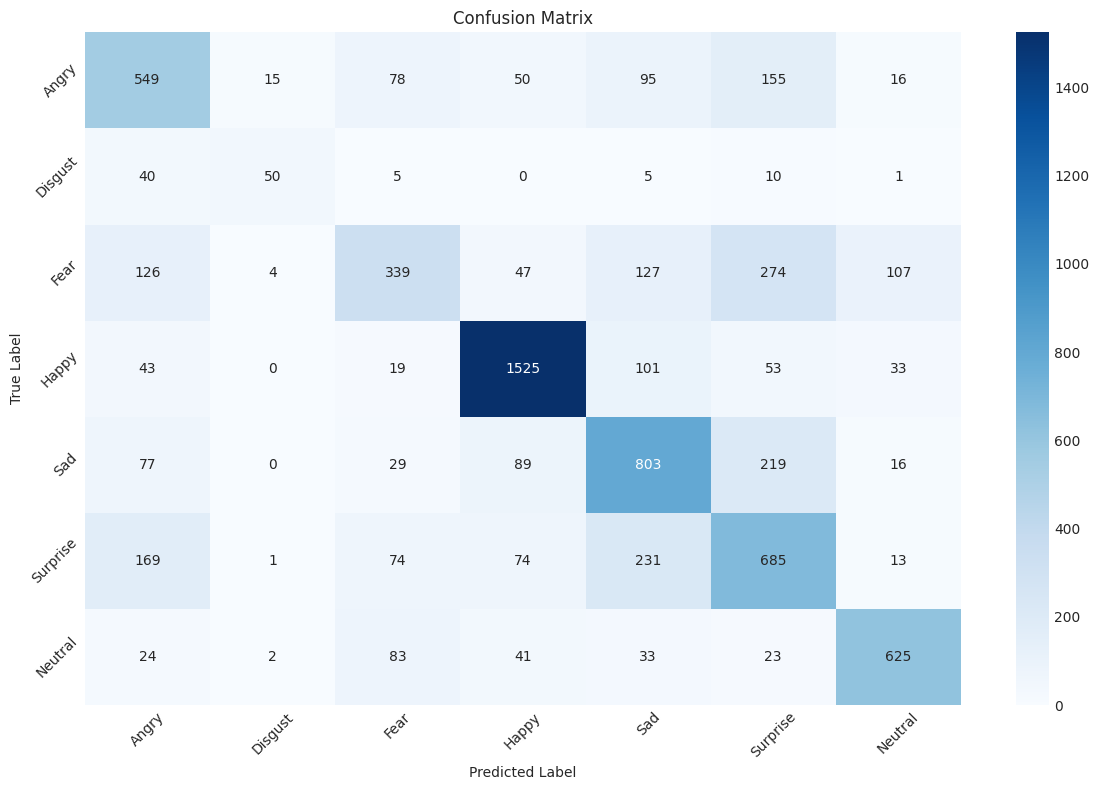


Classification Report:
              precision    recall  f1-score   support

       Angry       0.53      0.57      0.55       958
     Disgust       0.69      0.45      0.55       111
        Fear       0.54      0.33      0.41      1024
       Happy       0.84      0.86      0.85      1774
         Sad       0.58      0.65      0.61      1233
    Surprise       0.48      0.55      0.51      1247
     Neutral       0.77      0.75      0.76       831

    accuracy                           0.64      7178
   macro avg       0.63      0.60      0.61      7178
weighted avg       0.64      0.64      0.63      7178



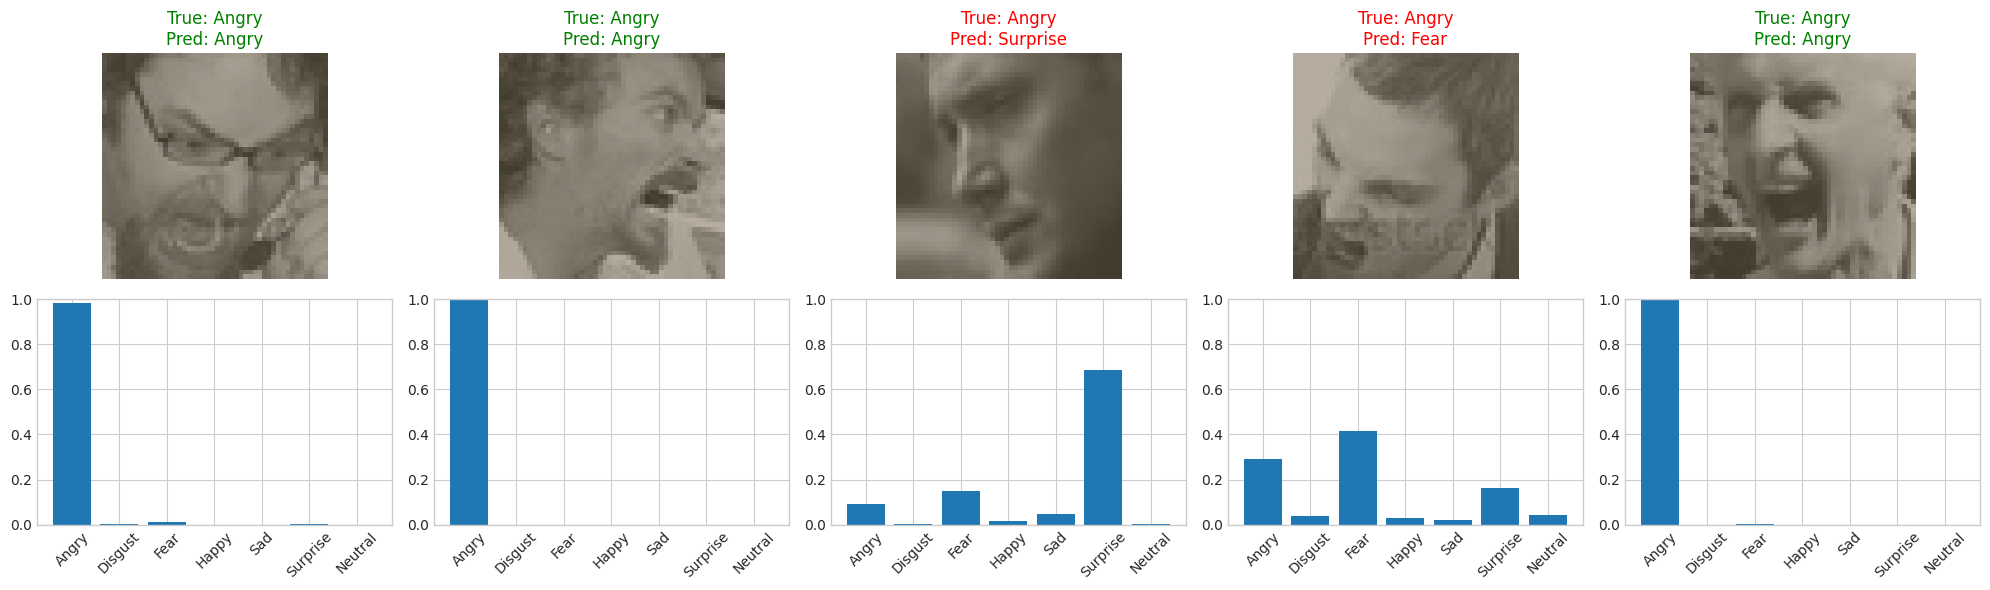

In [4]:
print_parameter_details(model)

pt_path, ptl_path = convert_all_formats('ResEmoteNetCNN_model.pth', 'ResEmoteNet')

plot_training_curves(history)

# Definisikan nama kelas sesuai dengan dataset FER2013
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Evaluasi model dan tampilkan confusion matrix
evaluate_model(model, val_loader, device, class_names)

# Tampilkan contoh prediksi
plot_sample_predictions(model, val_loader, device, class_names)